In [ ]:
import os, sys  
from google.colab import drive  
drive.mount('/content/drive')   

!pip install pycaret
!pip install markupsafe==2.0.1

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 59.3 MB/s 
     |████████████████████████████████| 88 kB 9.9 MB/s 
     |████████████████████████████████| 1.7 MB 48.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 120 kB 61.4 MB/s 
     |████████████████████████████████| 262 kB 64.5 MB/s 
     |████████████████████████████████| 17.8 MB 77.7 MB/s 
     |████████████████████████████████| 6.8 MB 55.5 MB/s 
     |████████████████████████████████| 167 kB 79.2 MB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
     |████████████████████████████████| 1.3 MB 57.6 MB/s 
     |████████████████████████████████| 1.3 MB 51.2 MB/s 
     |████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pycaret.utils import enable_colab
from pycaret.regression import *
enable_colab()

Colab mode enabled.


In [ ]:
# Data Load
%cd '/content/drive/MyDrive/Github/project_ddareungi'

df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

/content/drive/MyDrive/Github/project_ddareungi


In [ ]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent'))]
 ) # hour은 standardscaler에서 표준편차로 나누는 것은 제외함.

cat_feature = ['precip']
cat_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy="most_frequent"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", cat_transformer, cat_feature)
    ]
)

In [ ]:
X_train_p = pd.DataFrame(preprocessor.fit_transform(X_train))
X_val_p = pd.DataFrame(preprocessor.fit_transform(X_val))

In [ ]:
# Preprocessed data > to whole Dataframe
data_train = pd.concat([X_train_p,pd.Series(y_train)],axis=1)
data_test = pd.concat([X_val_p,pd.Series(y_val)],axis=1)

columns = numeric_features+hour_feature+cat_feature+['y']
data_train.columns = columns
data_test.columns = columns

data_train

,temp,windspeed,humidity,visibility,ozone,pm10,pm2_5,hour,precip,y
0,1.481695,0.795426,-0.937259,-0.258200,2.270666,1.844735,1.403782,18.0,0.0,303.0
1,0.254224,-1.095448,-0.739534,-0.763245,-0.416677,3.676272,0.591401,22.0,0.0,172.0
2,-0.557795,-1.531803,0.941132,-1.519081,1.495471,0.830848,1.477635,6.0,0.0,9.0
3,-0.255648,-1.386351,-0.294651,1.018247,-0.054919,-0.183038,-0.220980,1.0,0.0,70.0
4,0.084267,1.159056,-1.085553,1.018247,0.203479,-0.019508,-0.516391,18.0,0.0,303.0
...,...,...,...,...,...,...,...,...,...,...
1016,-1.407582,-1.459077,0.001937,-1.057277,-0.054919,-0.183038,-0.220980,1.0,0.0,26.0
1017,1.519463,1.740863,-0.739534,-0.074863,1.547151,0.209434,0.222137,17.0,0.0,229.0
1018,0.971822,2.540849,-1.481004,0.554713,0.668596,0.307552,0.222137,14.0,0.0,243.0
1019,0.707444,0.431797,-0.739534,1.018247,-0.261638,-0.837159,-1.033361,20.0,0.0,219.0


In [ ]:
# Pycaret env setup
reg_auto = setup(
    data = data_train, target = 'y', session_id = 100,
    normalize = True, transformation = True, transform_target = True, ## Response Variable normalize
    categorical_features=['precip'],
    remove_multicollinearity = True, ## 다중공선성 제거
    multicollinearity_threshold = 0.90,
    silent = True, use_gpu = True, log_experiment = True, experiment_name = 'logs' # 기타 세팅
)

,Description,Value
0,session_id,100
1,Target,y
2,Original Data,"(1021, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(714, 9)"


In [ ]:
best = compare_models(sort = 'RMSE', fold = 10) # 10-fold CV

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,29.2466,1842.6723,42.4077,0.7244,0.5296,0.9472,0.595
rf,Random Forest Regressor,29.9129,1918.3446,43.1835,0.7126,0.5582,1.0160,0.843
lightgbm,Light Gradient Boosting Machine,30.2563,2004.4914,44.2431,0.7018,0.5624,1.0708,0.062
gbr,Gradient Boosting Regressor,30.6272,2027.0569,44.6614,0.6965,0.5381,0.9436,0.131
ada,AdaBoost Regressor,36.5585,2579.3534,50.6040,0.6136,0.6261,1.1275,0.103
huber,Huber Regressor,38.6173,2963.0587,54.3019,0.5528,0.7168,1.1807,0.033
lr,Linear Regression,39.0038,2980.9946,54.4707,0.5510,0.7179,1.1775,0.010
lar,Least Angle Regression,39.0038,2980.9944,54.4707,0.5510,0.7179,1.1775,0.021
ridge,Ridge Regression,39.0229,2983.0173,54.4896,0.5507,0.7166,1.1907,0.023
br,Bayesian Ridge,39.0951,2990.6227,54.5603,0.5496,0.7161,1.2224,0.023


In [ ]:
lightgbm = create_model('lightgbm', fold = 10) # 10-fold CV

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.3877,2384.2210,48.8285,0.7410,0.7236,2.0895
1,34.8604,3533.3033,59.4416,0.5022,0.8177,3.5665
2,24.2142,1158.0824,34.0306,0.7853,0.5207,0.6556
3,28.5723,1899.8047,43.5867,0.7245,0.4740,0.4474
4,34.6490,2500.5505,50.0055,0.6575,0.5146,0.5959
5,29.4947,1491.4350,38.6191,0.7785,0.4907,0.6858
6,32.3171,1870.0830,43.2445,0.6667,0.5693,0.7978
7,31.6316,2003.8841,44.7648,0.6728,0.5646,0.6640
8,24.8999,1416.2728,37.6334,0.7554,0.5242,0.8308


In [ ]:
print(lightgbm)

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

In [ ]:
# Model Tuning
tuned_lightgbm = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.8906,2475.1983,49.7514,0.7311,0.7470,2.5288
1,37.6806,3732.4424,61.0937,0.4741,0.8312,3.4452
2,26.9143,1416.7075,37.6392,0.7374,0.5849,1.1829
3,30.9863,1940.0220,44.0457,0.7186,0.4756,0.4510
4,37.5137,2781.7932,52.7427,0.6190,0.5043,0.5588
5,32.7103,1857.6755,43.1008,0.7242,0.5694,1.2157
6,33.1952,2009.4514,44.8269,0.6419,0.6222,1.2355
7,32.2096,2214.7055,47.0607,0.6384,0.5923,0.8241
8,28.6695,1686.3538,41.0652,0.7088,0.5504,0.8935


In [ ]:
print(tuned_lightgbm) # hyperparameter tuning result

PowerTransformedTargetRegressor(bagging_fraction=0.9, bagging_freq=4,
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.8,
                                importance_type='split', learning_rate=0.2,
                                max_depth=-1, min_child_samples=41,
                                min_child_weight=0.001, min_split_gain=0.4,
                                n_estimators=50, n_jobs=-1, num_leaves=80,
                                objective=None,
                                power_transformer_method='bo...
                                                        importance_type='split',
                                                        learning_rate=0.2,
                                                        max_depth=-1,
                                                        min_child_samples=41,
                                                        min_child_weig

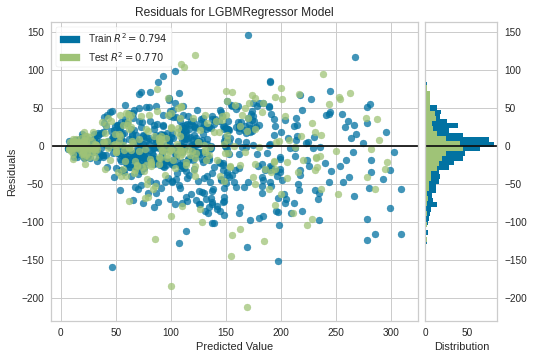

In [24]:
# Residual Plot
plot_model(tuned_lightgbm, plot="residuals")

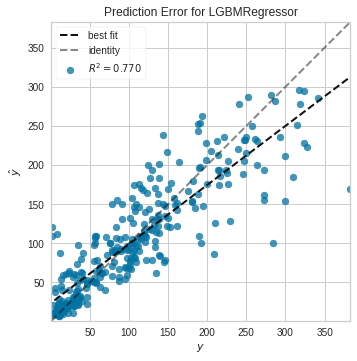

In [25]:
# Prediction Error
plot_model(tuned_lightgbm, plot = "error")

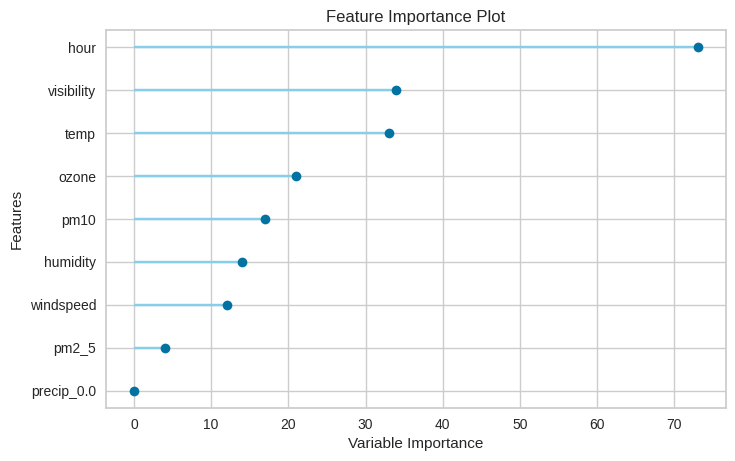

In [26]:
# Feature Importance
plot_model(tuned_lightgbm, plot = 'feature')

In [ ]:
# Model Finalizing

final_lightgbm = finalize_model(tuned_lightgbm)
print(final_lightgbm)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

In [ ]:
# Test dataset Prediction

test_predictions = predict_model(final_lightgbm, data = data_test)
test_predictions.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,27.9799,1559.5264,39.4908,0.7645,0.4942,0.6418


,temp,windspeed,humidity,visibility,ozone,pm10,pm2_5,hour,precip,y,Label
0,-0.806234,0.575921,1.559507,-1.203226,0.340688,-0.105101,-0.587206,3.0,0.0,17.0,22.958546
1,-1.103598,0.649017,1.462474,-0.479152,-0.551850,-0.839860,-0.069969,18.0,0.0,177.0,68.301055
2,0.977954,-0.739802,-0.623736,0.781649,-0.384499,-0.392616,-0.199278,10.0,0.0,81.0,122.010916
3,-1.004477,-0.081941,0.928792,-0.171969,0.173337,-0.296777,-0.328587,0.0,0.0,66.0,45.939709
4,0.184982,2.110932,-0.623736,0.999378,0.340688,-0.137047,-1.039789,11.0,0.0,110.0,86.536690


In [ ]:
# Check Metric

from pycaret.utils import check_metric
check_metric(test_predictions.y, test_predictions.Label, "RMSE") # 39.4908

39.4908